In [676]:

import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import csv

spending_data = pd.read_csv("data/yapikredi_formatted/yapikredi_spending_data.csv")
weather_data = json.load(open("data/weather_data.json"))

daily_spending = spending_data.groupby('date')['amount'].sum().reset_index()

temp_data = pd.DataFrame({
    'date': weather_data['daily']['time'],
    'temp_mean': weather_data['daily']['temperature_2m_mean'],
    'rain_sum': weather_data['daily']['rain_sum'],
    'snow_sum': weather_data['daily']['snowfall_sum']
})

# Merge spending and temperature data
merged_data = pd.merge(daily_spending, temp_data, on='date')



In [677]:
# outlier analysis
# get top 10 individual transactions with amounts and descriptions
top_spending = spending_data[['description', 'amount']].sort_values('amount', ascending=False)
print(top_spending.head(10))


# empty dataframe to store the new spending data
new_spending_data = pd.DataFrame()

# Filter the data, remove the data including "V.D." (taxes), "APPLE" (outlier, phone purchase)
for index, row in spending_data.iterrows():
    if not ("V.D." in row['description'] or "APPLE" in row['description'] or "AJET" in row['description'] or "Spotify" in row['description']):
        # dataframe has no attribute append, so use concat
        new_spending_data = pd.concat([new_spending_data, row.to_frame().T], ignore_index=True)

# save the data back to csv
new_spending_data.to_csv("data/yapikredi_formatted/yapikredi_spending_data.csv", index=False)


                           description   amount
262  MİGROS 5M VİAPORT AVM İSTİSTANBUL  8611.96
302        FENİX FENİX YALIKAVAK MUĞLA  7920.00
325    FAPEL GIDA İNŞAAT OTOMOİSTANBUL  4980.00
335        DEDECAN RESTAURANT İSTANBUL  2395.00
337  A-101 9935 H050 A101 METRİSTANBUL  1963.15
393    ATLI OTOMOTİV NAK.SAN.TİSTANBUL  1946.97
45                 EFDAL GIDA ISTANBUL  1050.00
253  MİGROS 5M VİAPORT AVM İSTİSTANBUL  1000.00
305       BODRUM BELEDIYESI GIDA MUGLA   996.00
113          TELVE PASTA CAFE İSTANBUL   985.00


In [686]:
# outlier analysis

# merchant analysis
merchant_spending = spending_data.groupby('description')['amount'].agg(['sum', 'count', 'mean']).sort_values('sum', ascending=False)
print("\nTop 10 Merchants by Total Spending:")
print(merchant_spending.head(10))




Top 10 Merchants by Total Spending:
                                        sum  count         mean
description                                                    
SELF GIDA SANAYI VE TICISTANBUL    12087.00     68   177.750000
MİGROS 5M VİAPORT AVM İSTİSTANBUL   9611.96      2  4805.980000
FENİX FENİX YALIKAVAK MUĞLA         7920.00      1  7920.000000
KUCUK EV SABANCI UNIVERISTANBUL     7664.00     56   136.857143
FAPEL GIDA İNŞAAT OTOMOİSTANBUL     4980.00      1  4980.000000
A-101 9935 H050 A101 METRİSTANBUL   2912.05      4   728.012500
ŞOK ŞOK 7036 İSTANBUL SABİSTANBUL   2842.45     24   118.435417
ATLI OTOMOTİV NAK.SAN.TİSTANBUL     2746.97      2  1373.485000
SABANCI ÜNİVERSİTESİ İSTANBUL       2714.50     32    84.828125
DEDECAN RESTAURANT İSTANBUL         2395.00      1  2395.000000


In [679]:
# Check duplicate data (same amount, same description, same date)
duplicate_data = spending_data[spending_data.duplicated(subset=['description', 'amount', 'date'])]
print(duplicate_data)

# looks like there are some duplicate transactions, 
# some of them are installments, no need to remove them
# some of them are actual transactions (something that I bought twice back to back)



     date                        description  amount
19     63    SELF GIDA SANAYI VE TICISTANBUL   170.0
112   106    İF PERFORMANCE HALL BEŞİSTANBUL   150.0
203   147    SELF GIDA SANAYI VE TICISTANBUL   190.0
220   154    SELF GIDA SANAYI VE TICISTANBUL   190.0
237   160    SELF GIDA SANAYI VE TICISTANBUL   215.0
287   202  PULLBEAR PULL BEAR MARMARİSTANBUL   450.0
289   202  PULLBEAR PULL BEAR MARMARİSTANBUL   450.0
404   278    İŞBİLİR GIDA İLETİŞİM İİSTANBUL   600.0


In [680]:
"""
So, I realised something here, previously I was using the `mean` method over my total spending per day on my merged data,
which is not correct, since in my merged data, the days with no spending at all are not included,
and this makes the average spending per day wrong.

for example, if my data looks like this (lets say 5 days between 1,5):
(assume all the days have the same temperature, 13)
1, X restaurant, 50
1, K restaurant, 50
2, Y restaurant, 100
5, Z restaurant, 100

mean of the total spending for the days with temp 13 should be (100+100+100)/5 = 60, right?

but when I take the mean of the merged data, I would get 100, since it would only count the days with spending, so as a solution
I will add placeholder spending with 0 amount for the days with no spending, and then take the mean of the data, this way I will get the correct mean
"""


"""
I will not add placeholder spending for the interval 164 to 168 (inclusive), 
since I was abroad in this interval and I dont have the spending data for these days (I was only using cash in Egypt).

This way the missing dates wont affect the mean. (from the same reason in above comment)
"""
for i in range(58, 164):
    if i not in spending_data['date'].values:
        new_row = pd.DataFrame({'date': [i], 'description': ['NO SPENDING'], 'amount': [0]})
        spending_data = pd.concat([spending_data, new_row], ignore_index=True)
for i in range(169, 337):
    if i not in spending_data['date'].values:
        new_row = pd.DataFrame({'date': [i], 'description': ['NO SPENDING'], 'amount': [0]})
        spending_data = pd.concat([spending_data, new_row], ignore_index=True)

# sort by date
spending_data = spending_data.sort_values('date')

# save the data back to csv
spending_data.to_csv("data/yapikredi_formatted/yapikredi_spending_data.csv", index=False)

/var/folders/fh/0nm6v2n92gldyxd0b7h3725m0000gn/T/ipykernel_25685/1850382289.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_spending = merged_data.groupby('temp_bin')['amount'].mean().reset_index()


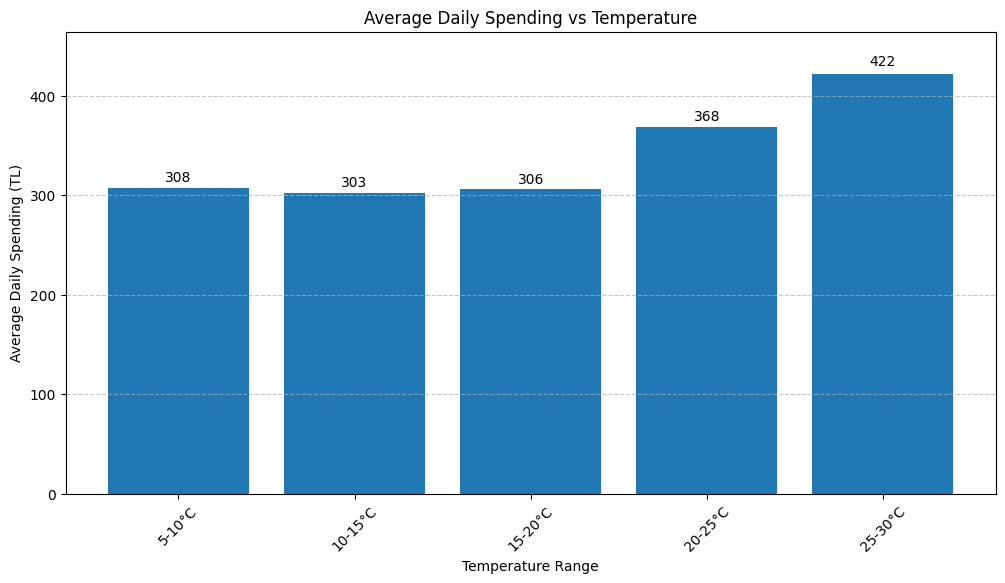

In [681]:

merged_data['temp_bin'] = pd.cut(merged_data['temp_mean'], 
                                bins=range(5, 35, 5),  # Creates bins: 5-10, 10-15, ..., 30-35
                                labels=[f'{i}-{i+5}°C' for i in range(5, 30, 5)])

# avg spending per temperature bin
temp_spending = merged_data.groupby('temp_bin')['amount'].mean().reset_index()

# plot
plt.figure(figsize=(12, 6))
plt.bar(temp_spending['temp_bin'], temp_spending['amount'])
plt.title('Average Daily Spending vs Temperature')
plt.xlabel('Temperature Range')
plt.ylabel('Average Daily Spending (TL)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust label position and add padding to the top of the plot
for i, v in enumerate(temp_spending['amount']):
    plt.text(i, v * 1.02, f'{v:.0f}', ha='center')  # Changed from v + 50 to v * 1.02

# Add some padding to the top of the plot to ensure labels are visible
plt.margins(y=0.1)  # Add 10% padding to the top

plt.show()

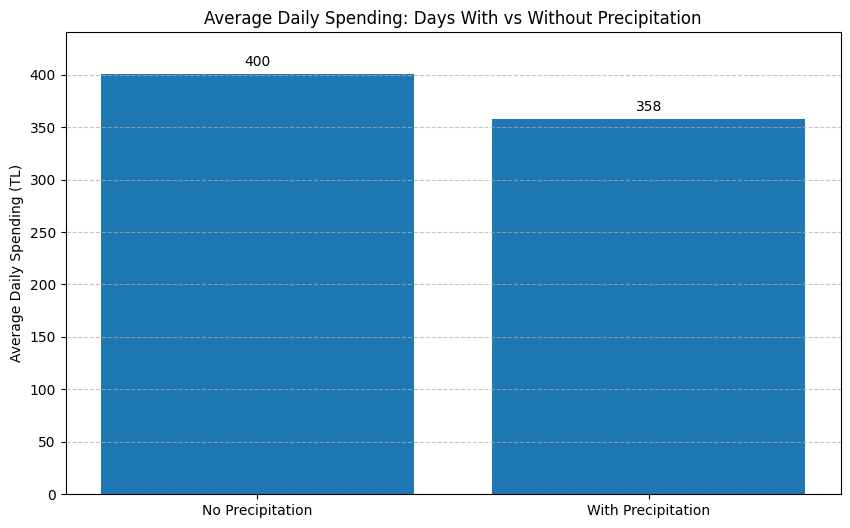


Average spending on days with vs without precipitation:
has_precipitation
False    400.315871
True     357.923058
Name: amount, dtype: float64

Percentage difference: -10.6% spending on days with precipitation


In [682]:
spending_data = pd.read_csv("data/yapikredi_formatted/yapikredi_spending_data.csv")
weather_data = json.load(open("data/weather_data.json"))

daily_spending = spending_data.groupby('date')['amount'].sum().reset_index()

temp_data = pd.DataFrame({
    'date': weather_data['daily']['time'],
    'temp_mean': weather_data['daily']['temperature_2m_mean'],
    'rain_sum': weather_data['daily']['rain_sum'],
    'snow_sum': weather_data['daily']['snowfall_sum']
})

# Merge spending and temperature data
merged_data = pd.merge(daily_spending, temp_data, on='date')



merged_data['has_precipitation'] = (merged_data['rain_sum'] > 0) | (merged_data['snow_sum'] > 0)

# calculate average spending for days with and without precipitation
precipitation_spending = merged_data.groupby('has_precipitation')['amount'].mean()

# plot
plt.figure(figsize=(10, 6))
bars = plt.bar(['No Precipitation', 'With Precipitation'], precipitation_spending)
plt.title('Average Daily Spending: Days With vs Without Precipitation')
plt.ylabel('Average Daily Spending (TL)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust label position by increasing the vertical offset
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height * 1.02,  # Changed from height + 50 to height * 1.02
             f'{height:.0f}',
             ha='center')

# Add some padding to the top of the plot to ensure labels are visible
plt.margins(y=0.1)  # Add 10% padding to the top

plt.show()

print("\nAverage spending on days with vs without precipitation:")
print(precipitation_spending)

pct_difference = ((precipitation_spending[True] - precipitation_spending[False]) / precipitation_spending[False]) * 100
print(f"\nPercentage difference: {pct_difference:.1f}% spending on days with precipitation")


